In [1]:
import pandas as pd
from pandas_profiling import ProfileReport

In [2]:
from sqlalchemy import create_engine, inspect
rds_config = {'DATABASE_TYPE': 'postgresql',
             'DBAPI': 'psycopg2',
             'ENDPOINT': "products.c8k7he1p0ynz.us-east-1.rds.amazonaws.com",
             'USER': 'postgres',
             'PASSWORD': 'aicore2022!',
             'PORT': 5432,
             'DATABASE': 'postgres'}
DATABASE_TYPE = rds_config['DATABASE_TYPE']
DBAPI = rds_config['DBAPI']
ENDPOINT = rds_config['ENDPOINT']
USER = rds_config['USER']
PASSWORD = rds_config['PASSWORD']
PORT = rds_config['PORT']
DATABASE = rds_config['DATABASE']
rds_engine = create_engine(
    f"{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{ENDPOINT}:{PORT}/{DATABASE}")
rds_engine.connect()


In [3]:
products = pd.read_sql_table('products', rds_engine)

In [19]:
from train_test_split import TrainTestSplitFBMarketData
help(TrainTestSplitFBMarketData)
data_splitter = TrainTestSplitFBMarketData(cat_drop=3)
train_data, test_date = data_splitter.train_test_split(products)


Help on class TrainTestSplitFBMarketData in module train_test_split:

class TrainTestSplitFBMarketData(builtins.object)
 |  Methods defined here:
 |  
 |  train_test_split(df)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



TypeError: TrainTestSplitFBMarketData() takes no arguments

In [32]:
products.info()
# products.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8091 entries, 0 to 8090
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   8091 non-null   object        
 1   product_name         8091 non-null   object        
 2   category             8091 non-null   object        
 3   product_description  8091 non-null   object        
 4   price                8091 non-null   object        
 5   location             8091 non-null   object        
 6   page_id              8091 non-null   int64         
 7   create_time          8091 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 505.8+ KB


In [5]:
import missingno as mss
%matplotlib inline

In [11]:
def split_string(text, sep):
    if text is None:
        return None
    l = text.split(sep)
    return [i.strip() for i in l]

def split_by_slash(text):
    return split_string(text, '/')

def split_by_comma(text):
    return split_string(text, ',')

def pop_top_word(word_l):
    if word_l:
        return word_l.pop(0)
    else: 
        return None


def split_expand_col(df, col_name, sep_func, cat_drop=None, rev=False):
    df_cat_list = df[col_name].apply(sep_func)
    if rev:
        df_cat_list = df_cat_list.apply(lambda x: x[::-1])
    cat_num = max(df_cat_list.apply(len))
    for i in range(cat_num):
        df[f'{col_name}_{i}'] = df_cat_list.apply(pop_top_word)
    drop_col = [col_name]
    if cat_drop: 
        drop_col.extend(
            [f'{col_name}_{cat_num - 1 - i}' for i in range(cat_drop)])
    df.drop(columns=drop_col, inplace=True)
    return df


products_df = products.replace({'N/A': None})
products_df['price'] = products_df['price'].str.replace('£', '')
products_df['price'] = products_df['price'].str.replace(',', '')
products_df['price'] = products_df['price'].astype('float')
products_df.dropna(inplace=True)
products_df.drop(columns=['id', 'page_id', 'create_time'], inplace=True)
products_df.info()
    
products_df = products.replace({'N/A':None})
products_df['price'] = products_df['price'].str.replace('£', '')
products_df['price'] = products_df['price'].str.replace(',', '')
products_df['price'] = products_df['price'].astype('float')
products_df.dropna(inplace=True)
products_df.drop(columns=['id', 'page_id', 'create_time'], inplace=True)
products_df.info()

products_df = split_expand_col(
    products_df, 'category', split_by_slash, cat_drop=3)
products_df = split_expand_col(
    products_df, 'location', split_by_comma, cat_drop=0, rev=True)

# # split the heirarchical categories into different columns
# products_cat_df = products_df['category']
# products_cat_list = products_cat_df.apply(split_by_slash)
# cat_nums = products_cat_list.apply(len).value_counts()
# for cat_num in range(max(cat_nums.index)):
#     products_df[f'cat_{cat_num}'] = products_cat_list.apply(pop_top_word)
# products_df.drop(columns=['category', 'cat_2', 'cat_3', 'cat_4'], inplace=True)

# # split the location into different columns
# products_loc_df = products_df['location']
# products_loc_list = products_loc_df.apply(split_by_comma)
# loc_nums = products_loc_list.apply(len).value_counts()
# for loc_num in range(max(loc_nums.index)):
#     products_df[f'loc_{loc_num}'] = products_loc_list.apply(pop_top_word)
# products_df.drop(columns=['location', 'loc_1'], inplace=True)
products_df.head(20)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7156 entries, 1 to 8090
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_name         7156 non-null   object 
 1   category             7156 non-null   object 
 2   product_description  7156 non-null   object 
 3   price                7156 non-null   float64
 4   location             7156 non-null   object 
dtypes: float64(1), object(4)
memory usage: 335.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7156 entries, 1 to 8090
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_name         7156 non-null   object 
 1   category             7156 non-null   object 
 2   product_description  7156 non-null   object 
 3   price                7156 non-null   float64
 4   location             7156 non-null   object 
dtypes: float64(1), object(4)
memo

,product_name,product_description,price,category_0,category_1,location_0,location_1
1,"Mirror wall art | in Wokingham, Berkshire | Gu...","Mirror wall art. Posted by Nisha in Dining, Li...",5.0,Home & Garden,"Dining, Living Room Furniture",Berkshire,Wokingham
2,"Stainless Steel Food Steamer | in Inverness, H...",Morphy Richard’s (model no 48755)Stainless ste...,20.0,Home & Garden,Other Household Goods,Highland,Inverness
3,"Sun loungers | in Skegness, Lincolnshire | Gum...",I have 2 of these - collection only as I don’t...,20.0,Home & Garden,Garden & Patio,Lincolnshire,Skegness
4,Coffee side table from Ammunition ammo box hai...,Great reclaimed army ammunition box used as co...,115.0,Home & Garden,"Dining, Living Room Furniture",Somerset,Radstock
5,Modern Shannon Sofa for sale at low cost | in ...,New Design Shannon Corner sofa 5 Seater Avail...,450.0,Home & Garden,"Dining, Living Room Furniture",Manchester,Delph
6,"Spotlights | in Newent, Gloucestershire | Gumtree",New in box not needed Spotlights . Posted by s...,9.0,Home & Garden,Other Household Goods,Gloucestershire,Newent
7,💥💥White Wardrobe💥💥Brand new Wardrobe For sale ...,🌈🌈Call Dustin 0208-0049437\r🌈🌈Same Day Or any...,419.0,Home & Garden,Beds & Bedroom Furniture,West Yorkshire,Huddersfield
8,"Letter cage | in Newent, Gloucestershire | Gum...",Selling for family member brand new too big fo...,10.0,Home & Garden,Other Household Goods,Gloucestershire,Newent
9,"Double Pine Bed Frame | in Lytham St Annes, La...",Double Pine bed frame good condition. Reasonab...,50.0,Home & Garden,Beds & Bedroom Furniture,Lancashire,Lytham St Annes
10,Solid pine dining table and chairs | in West K...,Distressed solid pine table and 4 chairs In ex...,200.0,Home & Garden,"Dining, Living Room Furniture",North Ayrshire,West Kilbride


In [ ]:
l = [1, 2, 3]
print(list.reverse(l))

In [13]:

len(products_df['location_1'].unique())

1569

In [10]:
len(products_df['category_0'].unique())


13

<AxesSubplot:>

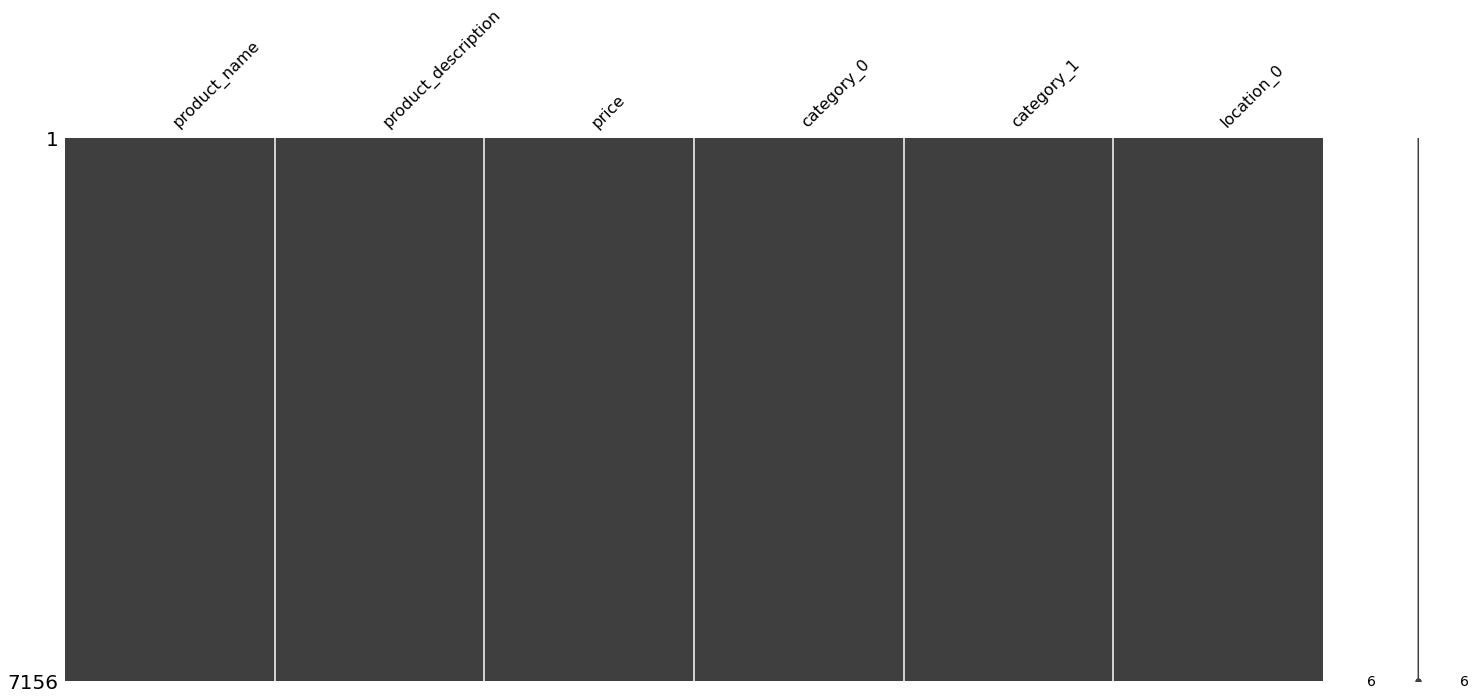

In [38]:
mss.matrix(products_df)


In [41]:
len(products_df['location_0'].unique())


101

<AxesSubplot:>

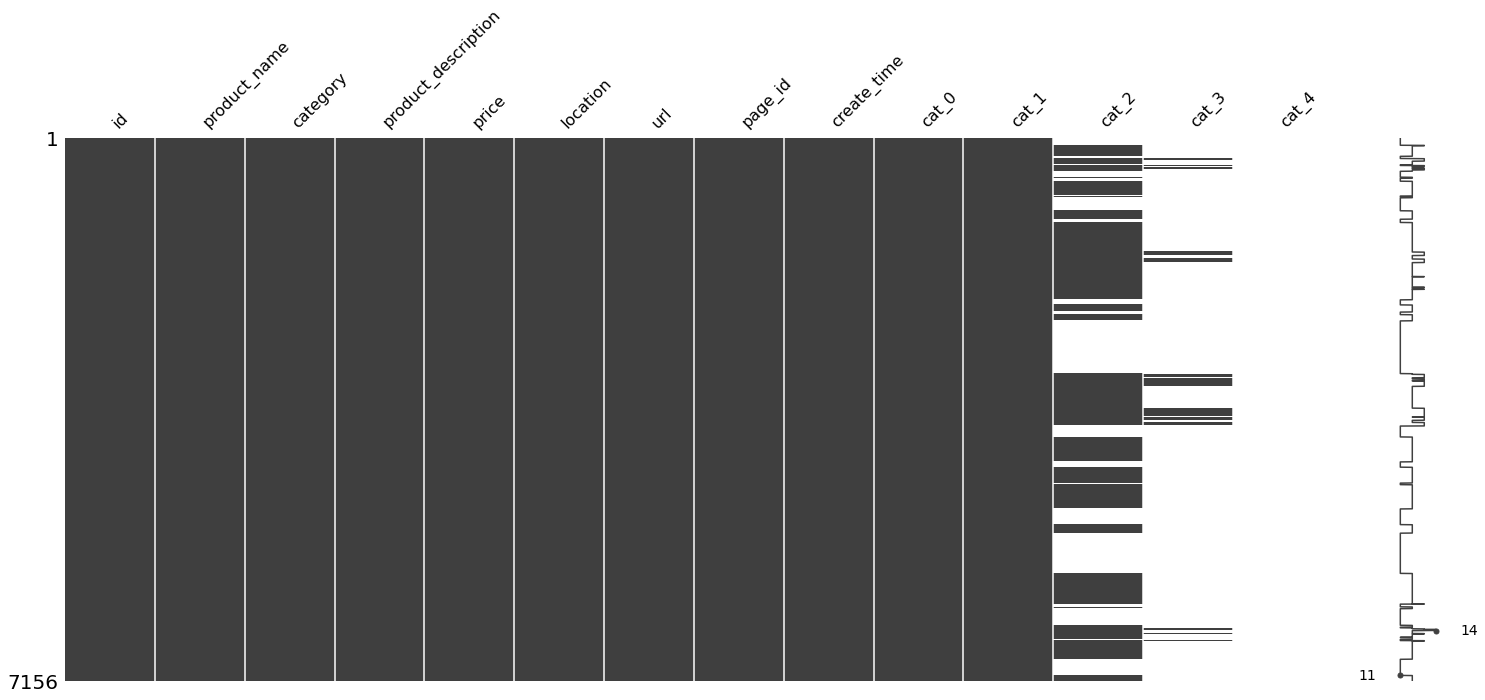

In [25]:
# products_df['location'].head(20)
products_df_sorted = products_df.sort_values(by=['category'])
products_df_sorted['product_name'].tail(20)
mss.matrix(products_df_sorted)

In [ ]:
# ts = products_df['location'].dropna().apply(lambda x: x.split(', '))


# products_df['city'] = products_df['location'].apply(lambda x: x.split(', ')[0] if x is not None else x)
# products_df['region'] = products_df['location'].apply(lambda x: x.split(', ')[1] if x is not None and len(x.split(', ')) else x)



In [ ]:
report = ProfileReport(products_df, title = "Sample Report")
report

In [1]:
from PIL import Image
import os
dir = os.getcwd() + "/data/images/"
file = "0a2d446d-f9ac-4715-992d-1bb30017e44d.jpg"
im = Image.open(dir+file)



In [2]:
im.mode
# im.size
# im.show()

'RGB'

In [ ]:
import torch
torch.cuda.is_available()
